In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from keras.models import Sequential
from keras.layers import Dense, Flatten, Embedding,Conv1D, MaxPooling1D,Input,Concatenate,SimpleRNN, GRU,Bidirectional,LSTM,concatenate, Dropout, BatchNormalization
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model

In [3]:
# Download NLTK resources
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [4]:
nltk.download('wordnet', "/kaggle/working/nltk_data/")
nltk.download('omw-1.4', "/kaggle/working/nltk_data/")
! unzip /kaggle/working/nltk_data/corpora/wordnet.zip -d /kaggle/working/nltk_data/corpora
! unzip /kaggle/working/nltk_data/corpora/omw-1.4.zip -d /kaggle/working/nltk_data/corpora
nltk.data.path.append("/kaggle/working/nltk_data/")

[nltk_data] Downloading package wordnet to
[nltk_data]     /kaggle/working/nltk_data/...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /kaggle/working/nltk_data/...
Archive:  /kaggle/working/nltk_data/corpora/wordnet.zip
   creating: /kaggle/working/nltk_data/corpora/wordnet/
  inflating: /kaggle/working/nltk_data/corpora/wordnet/lexnames  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/data.verb  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.adv  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.verb  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/data.adj  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/index.adj  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/nltk_data/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/nltk_data/c

In [5]:
data =pd.read_csv('/kaggle/input/emotions/text.csv')
data

,Unnamed: 0,text,label
0,0,i just feel really helpless and heavy hearted,4
1,1,ive enjoyed being able to slouch about relax a...,0
2,2,i gave up my internship with the dmrg and am f...,4
3,3,i dont know i feel so lost,0
4,4,i am a kindergarten teacher and i am thoroughl...,4
...,...,...,...
416804,416804,i feel like telling these horny devils to find...,2
416805,416805,i began to realize that when i was feeling agi...,3
416806,416806,i feel very curious be why previous early dawn...,5
416807,416807,i feel that becuase of the tyranical nature of...,3


In [6]:
print(data.keys())

Index(['Unnamed: 0', 'text', 'label'], dtype='object')


In [7]:
data = data.drop(['Unnamed: 0'], axis=1)
data

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4
...,...,...
416804,i feel like telling these horny devils to find...,2
416805,i began to realize that when i was feeling agi...,3
416806,i feel very curious be why previous early dawn...,5
416807,i feel that becuase of the tyranical nature of...,3


In [8]:
# Null Values 
data.isnull().sum()

text     0
label    0
dtype: int64

The emotions are classified into six categories: sadness (0), joy (1), love (2), anger (3), fear (4), and surprise (5).

In [9]:
# Head Of Data
data.head()

,text,label
0,i just feel really helpless and heavy hearted,4
1,ive enjoyed being able to slouch about relax a...,0
2,i gave up my internship with the dmrg and am f...,4
3,i dont know i feel so lost,0
4,i am a kindergarten teacher and i am thoroughl...,4


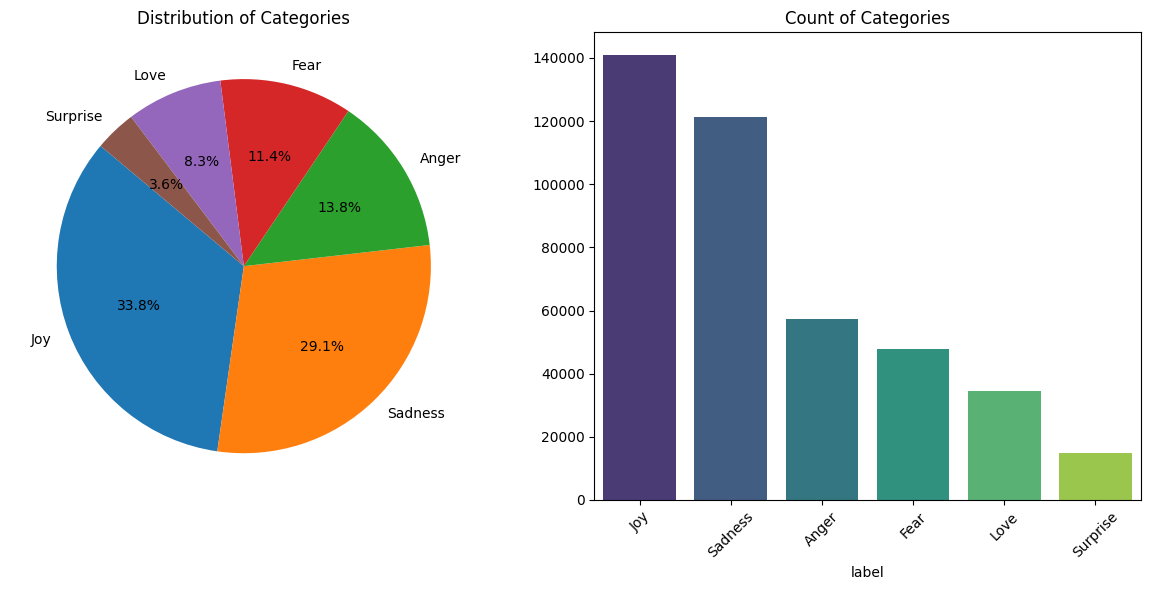

In [10]:
# Value Count Of Label
count = data['label'].value_counts()

# Map numeric labels to class names
label_names = {
    0: 'Sadness',
    1: 'Joy',
    2: 'Love',
    3: 'Anger',
    4: 'Fear',
    5: 'Surprise'
}

count.index = count.index.map(label_names)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of Categories')

# Rotate x-labels for better readability
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


In [11]:
# Group the data by label
grouped = data.groupby('label')

# Find the minimum number of samples among all labels
min_samples = grouped.size().min()

# Balance the dataset by randomly sampling 'min_samples' from each group
balanced_data = grouped.apply(lambda x: x.sample(min_samples)).reset_index(drop=True)

# Display the balanced dataset
print(balanced_data['label'].value_counts())


label
0    14972
1    14972
2    14972
3    14972
4    14972
5    14972
Name: count, dtype: int64


/tmp/ipykernel_35/2504370819.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_data = grouped.apply(lambda x: x.sample(min_samples)).reset_index(drop=True)


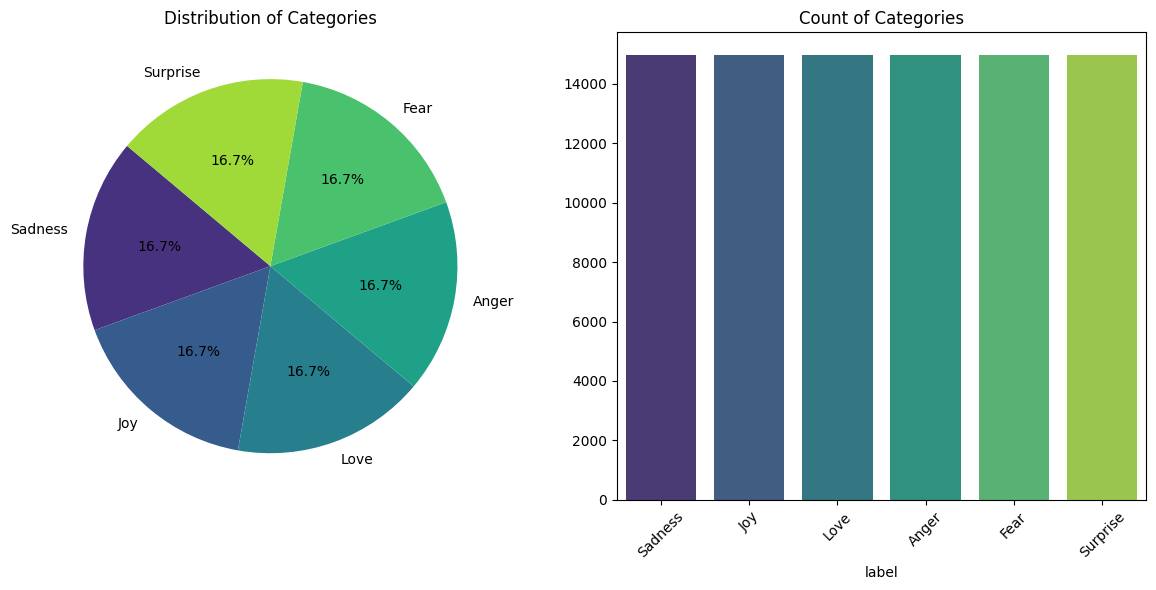

In [12]:
# Value Count Of Label
count = balanced_data['label'].value_counts()

# Map numeric labels to class names
label_names = {
    0: 'Sadness',
    1: 'Joy',
    2: 'Love',
    3: 'Anger',
    4: 'Fear',
    5: 'Surprise'
}

count.index = count.index.map(label_names)

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), facecolor='white')

# Plot pie chart on the first subplot
palette = sns.color_palette("viridis")
sns.set_palette(palette)
axs[0].pie(count, labels=count.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Categories')

# Plot bar chart on the second subplot
sns.barplot(x=count.index, y=count.values, ax=axs[1], palette="viridis")
axs[1].set_title('Count of Categories')

# Rotate x-labels for better readability
plt.setp(axs[1].xaxis.get_majorticklabels(), rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


Text(0, 0.5, 'Frequency')

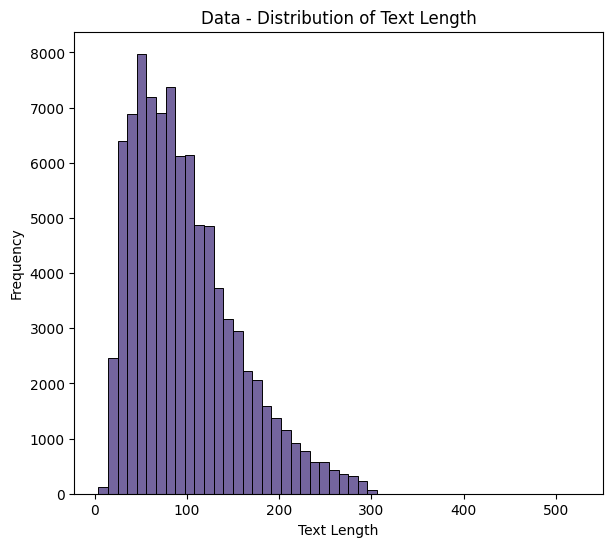

In [13]:
# Visualize a histogram of the text lengths for data
balanced_data['text_length'] = balanced_data['text'].apply(len)
plt.figure(figsize=(15,6))

plt.subplot(1, 2, 1)
sns.histplot(balanced_data['text_length'], bins=50)
plt.title('Data - Distribution of Text Length')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

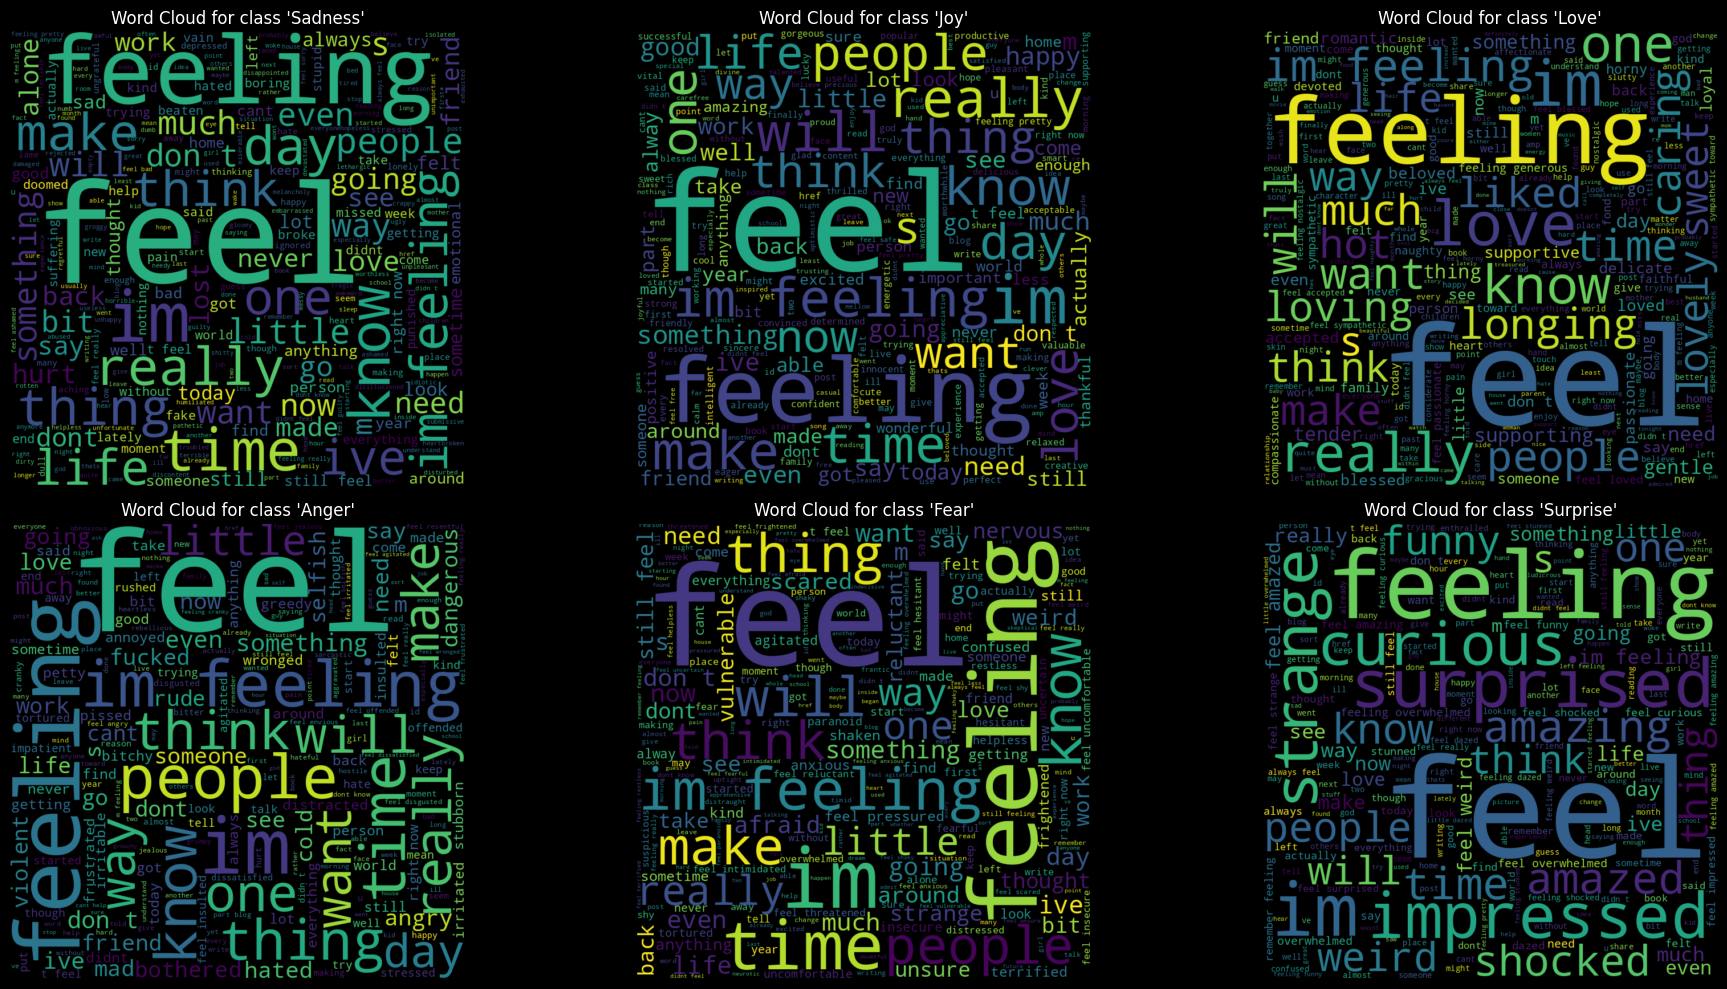

In [14]:
# Function to generate word cloud for a specific class
def generate_wordcloud(text, ax, title):
    wordcloud = WordCloud(width=800, height=800, 
                          background_color='black', 
                          stopwords=None, 
                          max_words=400,
                          min_font_size=10).generate(text)
    ax.imshow(wordcloud, interpolation='bilinear')
    ax.set_title(title, color='white')
    ax.axis("off")

# Generate word cloud for each class in subplots
fig, axs = plt.subplots(2, 3, figsize=(20, 10), facecolor='black')


for i, label in enumerate(balanced_data['label'].unique()):
    text = ' '.join(balanced_data[balanced_data['label'] == label]['text'])
    row = i // 3
    col = i % 3
    generate_wordcloud(text, axs[row, col], f"Word Cloud for class '{label_names[label]}'")

plt.tight_layout()
plt.show()


In [15]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    # Step 1: Remove URLs
    text = re.sub(r'http\S+|www\S+', '', text)
    
    # Step 2: Remove special characters and punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Step 3: Remove extra whitespaces
    text = re.sub(r'\s+', ' ', text)
    
    # Step 4: Remove numeric values
    text = re.sub(r'\d+', '', text)
    
    # Step 6: Lowercasing
    text = text.lower()
    
    # Tokenization
    words = word_tokenize(text)
    
    # Step 8: Remove stop words
    words = [word for word in words if word not in stop_words]
    
    # Step 9: Remove non-alphanumeric characters
    words = [word for word in words if word.isalnum()]
    
    # Lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]
    
    return ' '.join(words)

In [16]:
balanced_data['preprocessed_text'] = balanced_data['text'].apply(preprocess_text)
balanced_data

,text,label,text_length,preprocessed_text
0,ive forgotten how dirty this kind of attention...,0,82,ive forgotten dirty kind attention make person...
1,i slept for ten hours and woke up feeling grog...,0,70,slept ten hour woke feeling groggy fuck screw
2,i talked about how it was great that i wasnt m...,0,203,talked great wasnt made feel excluded unimport...
3,i wake up and i m feeling terrible,0,34,wake feeling terrible
4,i splash some water on my face and go back to ...,0,99,splash water face go back room feeling utterly...
...,...,...,...,...
89827,i feel all weird when i have to meet w people ...,5,86,feel weird meet w people text like dont talk f...
89828,i shake my hand off which feels slightly stunn...,5,68,shake hand feel slightly stunned making contact
89829,i could feel everyone watching me curious as t...,5,74,could feel everyone watching curious going choose
89830,i feel funny wow i managed to go to a final in...,5,86,feel funny wow managed go final interview thou...


In [17]:
balanced_data['preprocessed_text_length'] = balanced_data['preprocessed_text'].apply(len)
balanced_data

,text,label,text_length,preprocessed_text,preprocessed_text_length
0,ive forgotten how dirty this kind of attention...,0,82,ive forgotten dirty kind attention make person...,62
1,i slept for ten hours and woke up feeling grog...,0,70,slept ten hour woke feeling groggy fuck screw,45
2,i talked about how it was great that i wasnt m...,0,203,talked great wasnt made feel excluded unimport...,119
3,i wake up and i m feeling terrible,0,34,wake feeling terrible,21
4,i splash some water on my face and go back to ...,0,99,splash water face go back room feeling utterly...,75
...,...,...,...,...,...
89827,i feel all weird when i have to meet w people ...,5,86,feel weird meet w people text like dont talk f...,56
89828,i shake my hand off which feels slightly stunn...,5,68,shake hand feel slightly stunned making contact,47
89829,i could feel everyone watching me curious as t...,5,74,could feel everyone watching curious going choose,49
89830,i feel funny wow i managed to go to a final in...,5,86,feel funny wow managed go final interview thou...,54


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


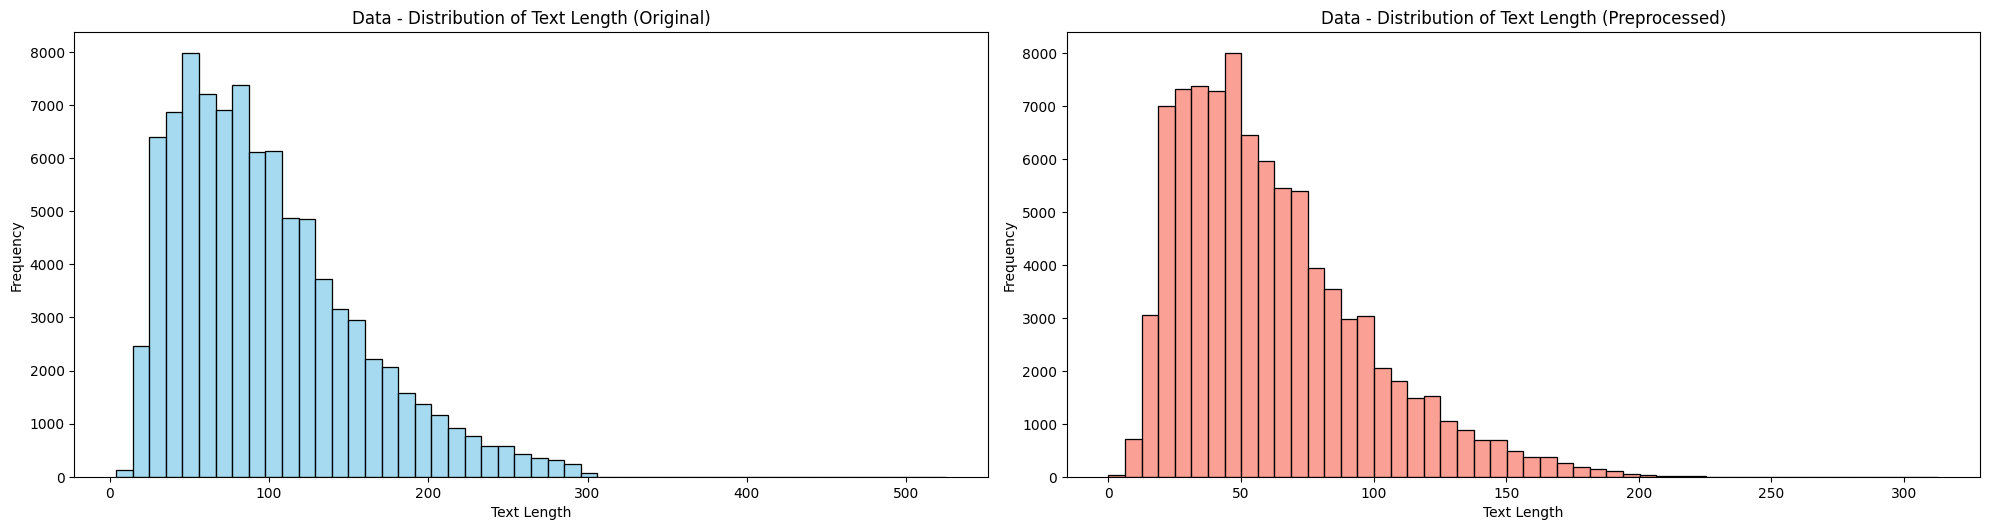

In [18]:
# Visualize a histogram of the text lengths for data
plt.figure(figsize=(20, 10))

plt.subplot(2, 2, 3)
sns.histplot(balanced_data['text_length'], bins=50, color='skyblue')
plt.title('Data - Distribution of Text Length (Original)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')


plt.subplot(2, 2, 4)
sns.histplot(balanced_data['preprocessed_text_length'], bins=50, color='salmon')
plt.title('Data - Distribution of Text Length (Preprocessed)')
plt.xlabel('Text Length')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

In [19]:
# Get the maximum length of text in the original text column
max_length_original = balanced_data['text_length'].max()
print("Maximum length of text in original column:", max_length_original)

# Get the maximum length of text in the preprocessed text column
max_length_preprocessed = balanced_data['preprocessed_text_length'].max()
print("Maximum length of text in preprocessed column:", max_length_preprocessed)


Maximum length of text in original column: 525
Maximum length of text in preprocessed column: 313


In [20]:
# Splits Dataset into Training and Testing set
train_data, test_data = train_test_split(balanced_data, test_size=0.2,random_state=100) 
print("Train Data size:", len(train_data))
print("Test Data size", len(test_data))

Train Data size: 71865
Test Data size 17967


In [21]:
from tensorflow.keras.preprocessing.text import Tokenizer

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_data.text)

word_index = tokenizer.word_index
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size :", vocab_size)

Vocabulary Size : 32685


In [22]:
x_train = pad_sequences(tokenizer.texts_to_sequences(train_data.text), maxlen = max_length_preprocessed)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_data.text),maxlen = max_length_preprocessed)

print("Training X Shape:",x_train.shape)
print("Testing X Shape:",x_test.shape)

Training X Shape: (71865, 313)
Testing X Shape: (17967, 313)


In [23]:
y_train = np.array(train_data['label']).reshape(-1,1)
y_test = np.array(test_data['label']).reshape(-1,1)
print("Training Y Shape:",y_train.shape)
print("Testing Y Shape:",y_test.shape)

Training Y Shape: (71865, 1)
Testing Y Shape: (17967, 1)


In [24]:
print(y_train[:10])

[[2]
 [4]
 [3]
 [4]
 [1]
 [3]
 [1]
 [4]
 [4]
 [1]]


In [25]:
# labels are integers from 0 to 5
num_classes = 6

# One-hot encode the labels
y_train_encoded = to_categorical(y_train, num_classes)
y_test_encoded = to_categorical(y_test, num_classes)

print("Training Y Shape (One-Hot Encoded):", y_train_encoded.shape)
print("Testing Y Shape (One-Hot Encoded):", y_test_encoded.shape)

Training Y Shape (One-Hot Encoded): (71865, 6)
Testing Y Shape (One-Hot Encoded): (17967, 6)


In [26]:
embedding_layer = Embedding(vocab_size,100,input_length=max_length_preprocessed,trainable=False)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:86: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Build Models

In [42]:
models_names = []
models_accuracies = []
models_loss = []

1- RNN

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_10 (InputLayer)     │ (None, 313)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 313, 100)       │     3,268,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_10 (Conv1D)              │ (None, 309, 128)       │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_10 (MaxPooling1D) │ (None, 61, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_20 (SimpleRNN)       │ (None, 61, 120)        │        29,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_20          │ (None, 61, 120)        │           480 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 61, 120)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_21 (SimpleRNN)       │ (None, 100)            │        22,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_21          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 80)             │         8,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 64)             │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,399,142 (12.97 MB)

 Trainable params: 130,202 (508.60 KB)

 Non-trainable params: 3,268,940 (12.47 MB)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 20s 154ms/step - accuracy: 0.1731 - loss: 1.8662 - val_accuracy: 0.1682 - val_loss: 1.7949
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.1815 - loss: 1.7927 - val_accuracy: 0.1639 - val_loss: 1.8014
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.2241 - loss: 1.7531 - val_accuracy: 0.1679 - val_loss: 1.8379
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.3272 - loss: 1.5777 - val_accuracy: 0.1672 - val_loss: 1.9408
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.3973 - loss: 1.4343 - val_accuracy: 0.2806 - val_loss: 1.7094
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.4718 - loss: 1.2842 - val_accuracy: 0.1630 - val_loss: 8.1925
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.5259 - loss: 1.1675 - val_accuracy: 0.2346 - val_loss: 2.1461
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - accuracy: 0.5799 - loss: 1.0476 - val_accuracy: 0.1657 -

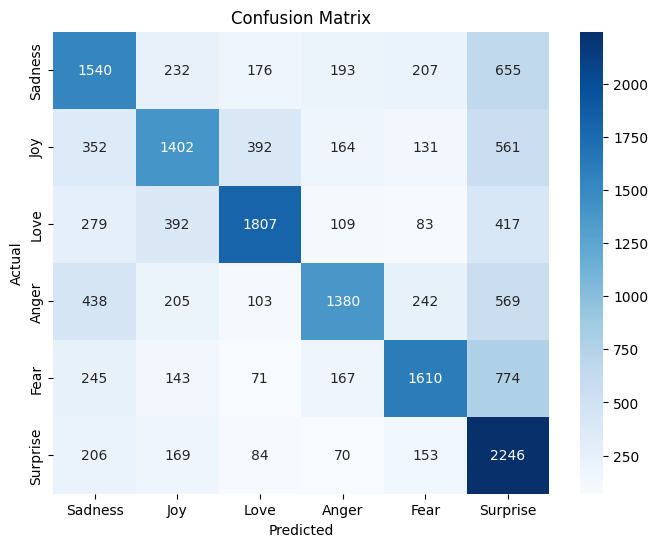

              precision    recall  f1-score   support

     Sadness       0.50      0.51      0.51      3003
         Joy       0.55      0.47      0.51      3002
        Love       0.69      0.59      0.63      3087
       Anger       0.66      0.47      0.55      2937
        Fear       0.66      0.53      0.59      3010
    Surprise       0.43      0.77      0.55      2928

    accuracy                           0.56     17967
   macro avg       0.58      0.56      0.56     17967
weighted avg       0.58      0.56      0.56     17967



In [43]:
# Define the model
sequence_input = Input(shape=(max_length_preprocessed,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)

# Add Conv1D and MaxPooling1D layers
x = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_sequences)
x = MaxPooling1D(pool_size=5)(x)

# Add RNN layers with BatchNormalization and Dropout
x = SimpleRNN(120, return_sequences=True)(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
x = SimpleRNN(100)(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

# Add Dense layers
x = Dense(80, activation='relu')(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(6, activation='softmax')(x)

# Create the model
model = Model(sequence_input, outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
# Train the model
history = model.fit(x_train, y_train_encoded, batch_size=1000, epochs=50,validation_data=(x_test,y_test_encoded))

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

models_names.append('RNN')
models_accuracies.append(accuracy)
models_loss.append(loss)

# Predict the classes
y_pred = np.argmax(model.predict(x_test), axis=-1)

# Convert one-hot encoded labels back to original labels
y_true = np.argmax(y_test_encoded, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_names.values(), yticklabels=label_names.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=label_names.values()))

2 - GRU

Model: "functional_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_11 (InputLayer)     │ (None, 313)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 313, 100)       │     3,268,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_11 (Conv1D)              │ (None, 309, 128)       │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_11 (MaxPooling1D) │ (None, 61, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 61, 120)        │        90,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_22          │ (None, 61, 120)        │           480 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 61, 120)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 100)            │        66,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 80)             │         8,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,503,762 (13.37 MB)

 Trainable params: 234,822 (917.27 KB)

 Non-trainable params: 3,268,940 (12.47 MB)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.1874 - loss: 1.8313 - val_accuracy: 0.1878 - val_loss: 1.7928
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.2923 - loss: 1.6638 - val_accuracy: 0.1640 - val_loss: 1.8036
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.4083 - loss: 1.4419 - val_accuracy: 0.2172 - val_loss: 1.7879
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.4981 - loss: 1.2431 - val_accuracy: 0.2231 - val_loss: 1.7779
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 62ms/step - accuracy: 0.5702 - loss: 1.0818 - val_accuracy: 0.2516 - val_loss: 1.7565
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.6205 - loss: 0.9583 - val_accuracy: 0.3782 - val_loss: 1.5532
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.6545 - loss: 0.8729 - val_accuracy: 0.3277 - val_loss: 1.6451
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.6766 - loss: 0.8125 - val_accuracy: 0.4472 - 

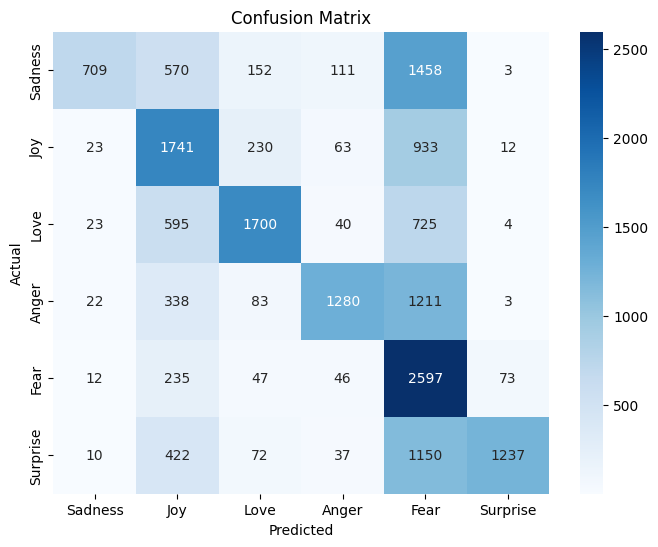

              precision    recall  f1-score   support

     Sadness       0.89      0.24      0.37      3003
         Joy       0.45      0.58      0.50      3002
        Love       0.74      0.55      0.63      3087
       Anger       0.81      0.44      0.57      2937
        Fear       0.32      0.86      0.47      3010
    Surprise       0.93      0.42      0.58      2928

    accuracy                           0.52     17967
   macro avg       0.69      0.51      0.52     17967
weighted avg       0.69      0.52      0.52     17967



In [44]:
# Define the model
sequence_input = Input(shape=(max_length_preprocessed,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)

# Add Conv1D and MaxPooling1D layers
x = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_sequences)
x = MaxPooling1D(pool_size=5)(x)

# Add RNN layers with BatchNormalization and Dropout
x = GRU(120, return_sequences=True)(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
x = GRU(100)(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

# Add Dense layers
x = Dense(80, activation='relu')(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(6, activation='softmax')(x)

# Create the model
model = Model(sequence_input, outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
# Train the model
history = model.fit(x_train, y_train_encoded, batch_size=1000, epochs=50,validation_data=(x_test,y_test_encoded))

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

models_names.append('GRU')
models_accuracies.append(accuracy)
models_loss.append(loss)

# Predict the classes
y_pred = np.argmax(model.predict(x_test), axis=-1)

# Convert one-hot encoded labels back to original labels
y_true = np.argmax(y_test_encoded, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_names.values(), yticklabels=label_names.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=label_names.values()))

3 - LSTM

Model: "functional_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 313)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 313, 100)       │     3,268,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_12 (Conv1D)              │ (None, 309, 128)       │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_12 (MaxPooling1D) │ (None, 61, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 61, 120)        │       119,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 61, 120)        │           480 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 61, 120)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100)            │        88,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 100)            │           400 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_36 (Dense)                │ (None, 80)             │         8,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_37 (Dense)                │ (None, 64)             │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_38 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,555,082 (13.56 MB)

 Trainable params: 286,142 (1.09 MB)

 Non-trainable params: 3,268,940 (12.47 MB)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 69ms/step - accuracy: 0.1802 - loss: 1.8374 - val_accuracy: 0.1671 - val_loss: 1.7918
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.2602 - loss: 1.7182 - val_accuracy: 0.1693 - val_loss: 1.7944
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.3734 - loss: 1.5121 - val_accuracy: 0.1656 - val_loss: 1.7882
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.4603 - loss: 1.3290 - val_accuracy: 0.1629 - val_loss: 1.7913
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.5202 - loss: 1.1842 - val_accuracy: 0.1898 - val_loss: 1.7616
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step - accuracy: 0.5686 - loss: 1.0811 - val_accuracy: 0.3608 - val_loss: 1.6758
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.6049 - loss: 0.9837 - val_accuracy: 0.3798 - val_loss: 1.6173
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 64ms/step - accuracy: 0.6350 - loss: 0.9158 - val_accuracy: 0.3111 - v

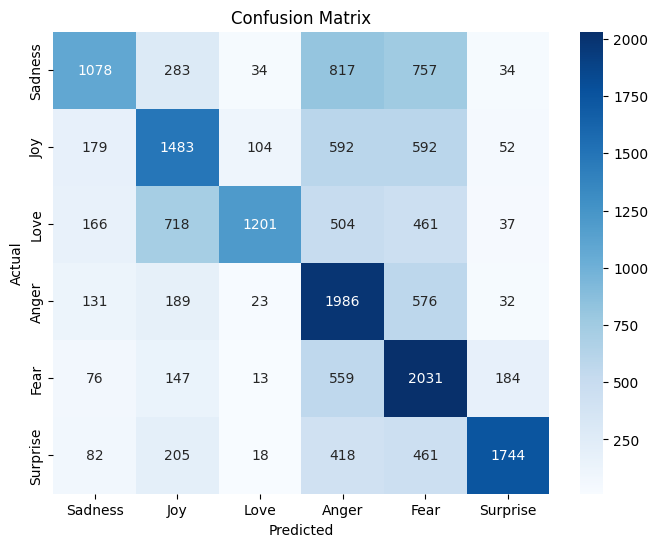

              precision    recall  f1-score   support

     Sadness       0.63      0.36      0.46      3003
         Joy       0.49      0.49      0.49      3002
        Love       0.86      0.39      0.54      3087
       Anger       0.41      0.68      0.51      2937
        Fear       0.42      0.67      0.51      3010
    Surprise       0.84      0.60      0.70      2928

    accuracy                           0.53     17967
   macro avg       0.61      0.53      0.53     17967
weighted avg       0.61      0.53      0.53     17967



In [45]:
# Define the model
sequence_input = Input(shape=(max_length_preprocessed,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)

# Add Conv1D and MaxPooling1D layers
x = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_sequences)
x = MaxPooling1D(pool_size=5)(x)

# Add RNN layers with BatchNormalization and Dropout
x = LSTM(120, return_sequences=True)(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
x = LSTM(100)(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

# Add Dense layers
x = Dense(80, activation='relu')(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(6, activation='softmax')(x)

# Create the model
model = Model(sequence_input, outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
# Train the model
history = model.fit(x_train, y_train_encoded, batch_size=1000, epochs=50,validation_data=(x_test,y_test_encoded))

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

models_names.append('LSTM')
models_accuracies.append(accuracy)
models_loss.append(loss)

# Predict the classes
y_pred = np.argmax(model.predict(x_test), axis=-1)

# Convert one-hot encoded labels back to original labels
y_true = np.argmax(y_test_encoded, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_names.values(), yticklabels=label_names.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=label_names.values()))

4 - Bi_RNN

Model: "functional_27"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_13 (InputLayer)     │ (None, 313)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 313, 100)       │     3,268,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_13 (Conv1D)              │ (None, 309, 128)       │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_13 (MaxPooling1D) │ (None, 61, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 61, 240)        │        59,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 61, 240)        │           960 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 61, 240)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 200)            │        68,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_27          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 80)             │        16,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 64)             │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,484,002 (13.29 MB)

 Trainable params: 214,622 (838.37 KB)

 Non-trainable params: 3,269,380 (12.47 MB)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 27s 219ms/step - accuracy: 0.1720 - loss: 1.8775 - val_accuracy: 0.1673 - val_loss: 1.8053
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.1815 - loss: 1.8020 - val_accuracy: 0.1668 - val_loss: 1.8203
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.2245 - loss: 1.7611 - val_accuracy: 0.1743 - val_loss: 1.8823
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.3294 - loss: 1.5748 - val_accuracy: 0.2068 - val_loss: 1.7620
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.4152 - loss: 1.4052 - val_accuracy: 0.1630 - val_loss: 6.6827
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.4845 - loss: 1.2549 - val_accuracy: 0.1630 - val_loss: 6.4286
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.5427 - loss: 1.1298 - val_accuracy: 0.1953 - val_loss: 4.1202
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 7s 98ms/step - accuracy: 0.5893 - loss: 1.0188 - val_accuracy: 0.1931 -

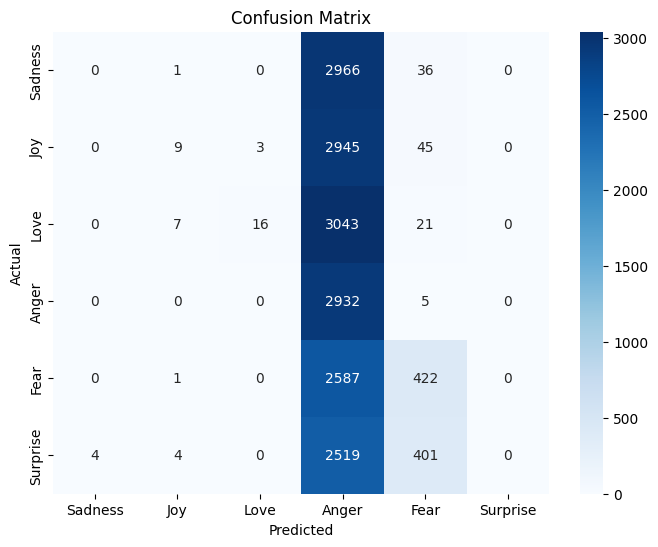

              precision    recall  f1-score   support

     Sadness       0.00      0.00      0.00      3003
         Joy       0.41      0.00      0.01      3002
        Love       0.84      0.01      0.01      3087
       Anger       0.17      1.00      0.29      2937
        Fear       0.45      0.14      0.21      3010
    Surprise       0.00      0.00      0.00      2928

    accuracy                           0.19     17967
   macro avg       0.31      0.19      0.09     17967
weighted avg       0.32      0.19      0.09     17967



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [47]:
# Define the model
sequence_input = Input(shape=(max_length_preprocessed,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)

# Add Conv1D and MaxPooling1D layers
x = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_sequences)
x = MaxPooling1D(pool_size=5)(x)

# Add RNN layers with BatchNormalization and Dropout
x = Bidirectional(SimpleRNN(120, return_sequences=True))(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
x = Bidirectional(SimpleRNN(100))(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

# Add Dense layers
x = Dense(80, activation='relu')(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(6, activation='softmax')(x)

# Create the model
model = Model(sequence_input, outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
# Train the model
history = model.fit(x_train, y_train_encoded, batch_size=1000, epochs=50,validation_data=(x_test,y_test_encoded))

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

models_names.append('BI RNN')
models_accuracies.append(accuracy)
models_loss.append(loss)

# Predict the classes
y_pred = np.argmax(model.predict(x_test), axis=-1)

# Convert one-hot encoded labels back to original labels
y_true = np.argmax(y_test_encoded, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_names.values(), yticklabels=label_names.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=label_names.values()))

5 - Bi GRU

Model: "functional_29"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_14 (InputLayer)     │ (None, 313)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 313, 100)       │     3,268,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_14 (Conv1D)              │ (None, 309, 128)       │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_14 (MaxPooling1D) │ (None, 61, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 61, 240)        │       180,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_28          │ (None, 61, 240)        │           960 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 61, 240)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 200)            │       205,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_29          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 80)             │        16,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_43 (Dense)                │ (None, 64)             │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_44 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,741,242 (14.27 MB)

 Trainable params: 471,862 (1.80 MB)

 Non-trainable params: 3,269,380 (12.47 MB)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 12s 116ms/step - accuracy: 0.1880 - loss: 1.8180 - val_accuracy: 0.1728 - val_loss: 1.7918
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.3026 - loss: 1.6554 - val_accuracy: 0.1828 - val_loss: 1.7870
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.4295 - loss: 1.3975 - val_accuracy: 0.1940 - val_loss: 1.7703
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.5270 - loss: 1.1758 - val_accuracy: 0.2265 - val_loss: 1.7142
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 109ms/step - accuracy: 0.5960 - loss: 1.0154 - val_accuracy: 0.2397 - val_loss: 1.7006
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.6407 - loss: 0.9012 - val_accuracy: 0.3706 - val_loss: 1.5614
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.6719 - loss: 0.8253 - val_accuracy: 0.4449 - val_loss: 1.3885
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 108ms/step - accuracy: 0.6895 - loss: 0.7750 - val_accuracy: 0

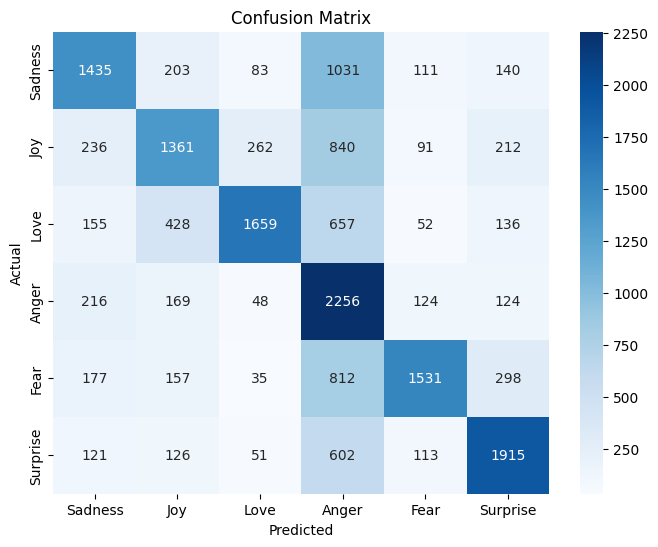

              precision    recall  f1-score   support

     Sadness       0.61      0.48      0.54      3003
         Joy       0.56      0.45      0.50      3002
        Love       0.78      0.54      0.64      3087
       Anger       0.36      0.77      0.49      2937
        Fear       0.76      0.51      0.61      3010
    Surprise       0.68      0.65      0.67      2928

    accuracy                           0.57     17967
   macro avg       0.62      0.57      0.57     17967
weighted avg       0.63      0.57      0.57     17967



In [48]:
# Define the model
sequence_input = Input(shape=(max_length_preprocessed,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)

# Add Conv1D and MaxPooling1D layers
x = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_sequences)
x = MaxPooling1D(pool_size=5)(x)

# Add RNN layers with BatchNormalization and Dropout
x = Bidirectional(GRU(120, return_sequences=True))(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
x = Bidirectional(GRU(100))(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

# Add Dense layers
x = Dense(80, activation='relu')(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(6, activation='softmax')(x)

# Create the model
model = Model(sequence_input, outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
# Train the model
history = model.fit(x_train, y_train_encoded, batch_size=1000, epochs=50,validation_data=(x_test,y_test_encoded))

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

models_names.append('BI GRU')
models_accuracies.append(accuracy)
models_loss.append(loss)

# Predict the classes
y_pred = np.argmax(model.predict(x_test), axis=-1)

# Convert one-hot encoded labels back to original labels
y_true = np.argmax(y_test_encoded, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_names.values(), yticklabels=label_names.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=label_names.values()))

6 - BI LSTM

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_15 (InputLayer)     │ (None, 313)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 313, 100)       │     3,268,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_15 (Conv1D)              │ (None, 309, 128)       │        64,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_15 (MaxPooling1D) │ (None, 61, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_4 (Bidirectional) │ (None, 61, 240)        │       239,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_30          │ (None, 61, 240)        │           960 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 61, 240)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 200)            │       272,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_31          │ (None, 200)            │           800 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_45 (Dense)                │ (None, 80)             │        16,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_46 (Dense)                │ (None, 64)             │         5,184 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_47 (Dense)                │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,867,882 (14.75 MB)

 Trainable params: 598,502 (2.28 MB)

 Non-trainable params: 3,269,380 (12.47 MB)

Epoch 1/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 15s 125ms/step - accuracy: 0.1853 - loss: 1.8191 - val_accuracy: 0.1671 - val_loss: 1.7909
Epoch 2/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.3228 - loss: 1.6157 - val_accuracy: 0.1671 - val_loss: 1.7902
Epoch 3/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.4337 - loss: 1.3891 - val_accuracy: 0.1778 - val_loss: 1.7896
Epoch 4/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 116ms/step - accuracy: 0.5171 - loss: 1.2048 - val_accuracy: 0.2793 - val_loss: 1.7516
Epoch 5/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.5739 - loss: 1.0656 - val_accuracy: 0.3864 - val_loss: 1.6475
Epoch 6/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.6197 - loss: 0.9575 - val_accuracy: 0.3533 - val_loss: 1.5597
Epoch 7/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.6523 - loss: 0.8835 - val_accuracy: 0.4799 - val_loss: 1.3762
Epoch 8/50
72/72 ━━━━━━━━━━━━━━━━━━━━ 8s 117ms/step - accuracy: 0.6756 - loss: 0.8189 - val_accuracy: 0

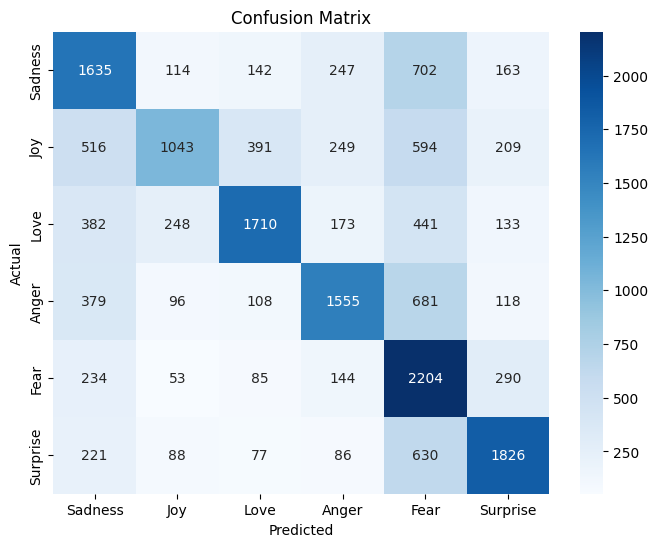

              precision    recall  f1-score   support

     Sadness       0.49      0.54      0.51      3003
         Joy       0.64      0.35      0.45      3002
        Love       0.68      0.55      0.61      3087
       Anger       0.63      0.53      0.58      2937
        Fear       0.42      0.73      0.53      3010
    Surprise       0.67      0.62      0.64      2928

    accuracy                           0.56     17967
   macro avg       0.59      0.56      0.55     17967
weighted avg       0.59      0.56      0.55     17967



In [49]:
# Define the model
sequence_input = Input(shape=(max_length_preprocessed,), dtype='int32')
embedding_sequences = embedding_layer(sequence_input)

# Add Conv1D and MaxPooling1D layers
x = Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_sequences)
x = MaxPooling1D(pool_size=5)(x)

# Add RNN layers with BatchNormalization and Dropout
x = Bidirectional(LSTM(120, return_sequences=True))(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)
x = Bidirectional(LSTM(100))(x)
x = BatchNormalization()(x)
x = Dropout(0.1)(x)

# Add Dense layers
x = Dense(80, activation='relu')(x)
x = Dense(64, activation='relu')(x)
outputs = Dense(6, activation='softmax')(x)

# Create the model
model = Model(sequence_input, outputs)

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()
# Train the model
history = model.fit(x_train, y_train_encoded, batch_size=1000, epochs=50,validation_data=(x_test,y_test_encoded))

# Evaluate the model
loss, accuracy = model.evaluate(x_test, y_test_encoded)
print("Test Loss:", loss)
print("Test Accuracy:", accuracy)

models_names.append('BI LSTM')
models_accuracies.append(accuracy)
models_loss.append(loss)

# Predict the classes
y_pred = np.argmax(model.predict(x_test), axis=-1)

# Convert one-hot encoded labels back to original labels
y_true = np.argmax(y_test_encoded, axis=1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_names.values(), yticklabels=label_names.values())
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=label_names.values()))

In [50]:
print(models_names)
print(models_accuracies)
print(models_loss )

['RNN', 'GRU', 'LSTM', 'BI RNN', 'BI GRU', 'BI LSTM']
[0.5557410717010498, 0.5156119465827942, 0.5300272703170776, 0.1880670189857483, 0.5653141736984253, 0.5550732016563416]
[1.6958757638931274, 3.1140785217285156, 2.197110652923584, 25.67674446105957, 2.679598569869995, 2.38950514793396]


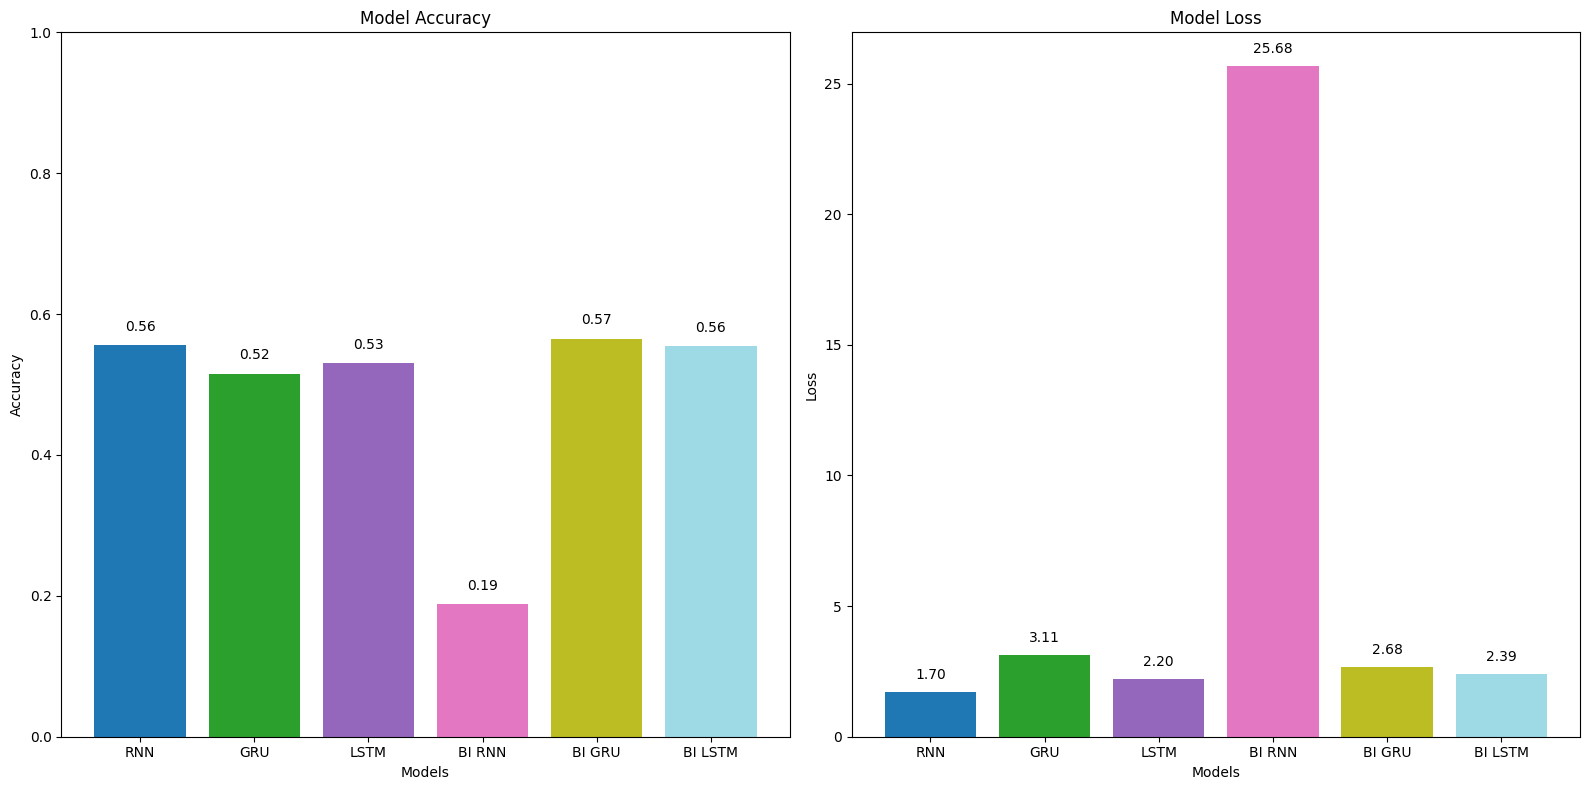

In [54]:
# Colors for bars
colors = plt.cm.tab20(np.linspace(0, 1, len(models_names)))

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# Subplot for Accuracy
axes[0].bar(models_names, models_accuracies, color=colors)
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Models')
axes[0].set_ylabel('Accuracy')
axes[0].set_ylim(0, 1)  # Accuracy is between 0 and 1
for i, v in enumerate(models_accuracies):
    axes[0].text(i, v + 0.02, f"{v:.2f}", ha='center')

# Subplot for Loss
axes[1].bar(models_names, models_loss, color=colors)
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Models')
axes[1].set_ylabel('Loss')
for i, v in enumerate(models_loss):
    axes[1].text(i, v + 0.5, f"{v:.2f}", ha='center')

plt.tight_layout()
plt.show()